In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import glob
import pandas as pd

from npc_sessions.trials.TaskControl import DynamicRouting1 as DR1

%matplotlib widget
%load_ext autoreload
%autoreload 2

ImportError: cannot import name '_PosixFlavour' from 'pathlib' (c:\Users\SeaMonkey\Anaconda3\envs\npc_sessions\Lib\pathlib.py)

In [2]:
#set recording path
recording_path=r"D:\tilda data\recording1"
#this assumes your behavior file is in the above folder
behavior_file_path=glob.glob(os.path.join(recording_path, '*.hdf5'))[0]

aud_sync_channel = 2
photodiode_smoothing_window = 200 #in samples
pd_trigger_strategy = 'minmax' #minmax or median
flip_threshold = 0.3 #seconds; threshold above which to exclude photodiode flips

In [3]:
#find nidaq folders
nidaq_events_folder=glob.glob(os.path.join(recording_path,'events','NI-DAQmx*'))[0]
nidaq_continuous_folder=glob.glob(os.path.join(recording_path,'continuous','NI-DAQmx*'))[0]

#load nidaq events (digital inputs)
nidaq_events_states_path=os.path.join(nidaq_events_folder,'TTL','states.npy')
nidaq_events_timestamps_path=os.path.join(nidaq_events_folder,'TTL','timestamps.npy')
nidaq_events_states=np.load(nidaq_events_states_path)
nidaq_events_timestamps=np.load(nidaq_events_timestamps_path)

#load continuous nidaq data (analog input)
nidaq_continuous_path=os.path.join(nidaq_continuous_folder,'continuous.dat')
nidaq_continuous_timestamps_path=os.path.join(nidaq_continuous_folder,'timestamps.npy')
nidaq_continuous=np.fromfile(nidaq_continuous_path,dtype=np.int16)
nidaq_continuous_timestamps=np.load(nidaq_continuous_timestamps_path)

#reshape continuous data
nidaq_continuous_reshape=np.reshape(nidaq_continuous,(int(nidaq_continuous.shape[0]/8),8))

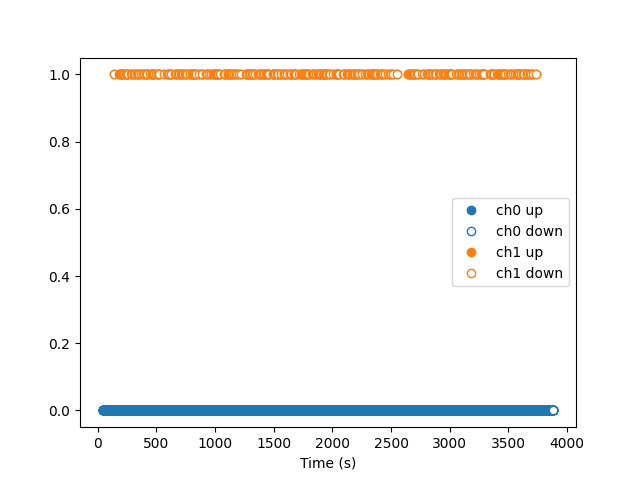

In [4]:
#plot events on a timeline

unique_inputs=np.unique(np.abs(nidaq_events_states))

colors=['tab:blue','tab:orange','tab:green','tab:red']

fig,ax=plt.subplots(1,1)
for ii,input in enumerate(unique_inputs):
    input_starts=nidaq_events_timestamps[nidaq_events_states==input]
    input_ends=nidaq_events_timestamps[nidaq_events_states==-input]

    ax.plot(input_starts,np.ones(len(input_starts))*ii,color=colors[ii],marker='o',linestyle='None',label=f'ch{ii} up')
    ax.plot(input_ends,np.ones(len(input_ends))*ii,color=colors[ii],marker='o',markerfacecolor='white',linestyle='None',label=f'ch{ii} down')

ax.set_xlabel('Time (s)')
ax.legend()


In [5]:
#get all rising/falling values

smoothing_window=np.ones(photodiode_smoothing_window)/photodiode_smoothing_window
photodiode_channel=1
photodiode_signal=nidaq_continuous_reshape[:,photodiode_channel]
timestamps=nidaq_continuous_timestamps[:]
#smooth photodiode signal
smoothed_signal=np.convolve(photodiode_signal,smoothing_window,mode='same')

#get trigger value
if pd_trigger_strategy=='minmax':
    trigger_val=(np.max(smoothed_signal)+np.min(smoothed_signal))/2
elif pd_trigger_strategy=='median':
    trigger_val=np.median(smoothed_signal)

#get rising/falling values
data=smoothed_signal
rising_mask = (data[:-1] < trigger_val) & (data[1:] > trigger_val)
falling_mask = (data[:-1] > trigger_val) & (data[1:] < trigger_val)
rising_falling_values=np.flatnonzero(rising_mask | falling_mask)


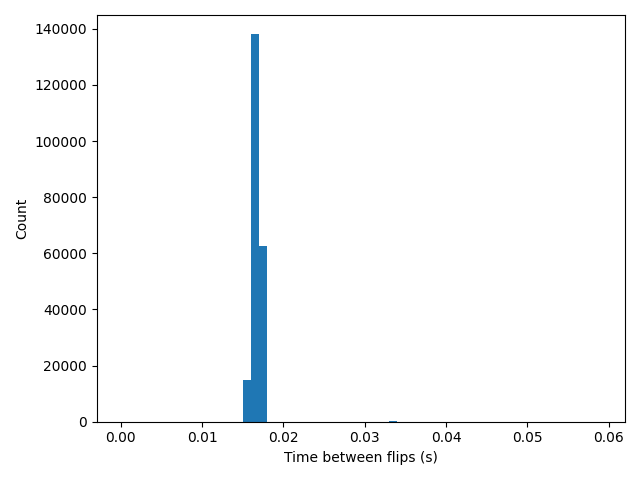

In [6]:
fig,ax=plt.subplots(1,1)
ax.hist(np.diff(timestamps[rising_falling_values]),bins=np.arange(0,0.06,0.001))
ax.set_xlabel('Time between flips (s)')
ax.set_ylabel('Count')

fig.tight_layout()

In [7]:
#remove spurious flips
flip_times=timestamps[rising_falling_values]
np.where(np.diff(flip_times)>flip_threshold)[0]

flip_times=flip_times[np.where(np.diff(flip_times)<flip_threshold)[0]]

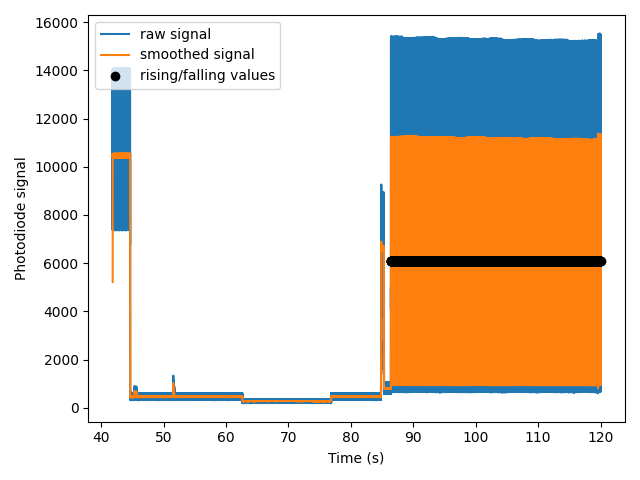

In [8]:
#plot to validate bad flips are removed (usually at the beginning of the recording) 
start_time=0
end_time=120
start_idx=np.where(timestamps>start_time)[0][0]
end_idx=np.where(timestamps>end_time)[0][0]

fig,ax=plt.subplots(1,1)
ax.plot(timestamps[start_idx:end_idx],photodiode_signal[start_idx:end_idx],label='raw signal')
ax.plot(timestamps[start_idx:end_idx],smoothed_signal[start_idx:end_idx],label='smoothed signal')
ax.plot(flip_times[flip_times<end_time],np.ones(np.sum(flip_times<end_time))*trigger_val,marker='o',color='k',linestyle='None',label='rising/falling values')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Photodiode signal')
ax.legend(loc='upper left')
fig.tight_layout()

In [9]:
#use npc_sessions to align visual stimulus presentation times
trials=DR1.DynamicRouting1(behavior_file_path,flip_times=flip_times,vis_display_times=flip_times,input_data_times=flip_times).to_dataframe()

#replace aud start times in trials table with nidaq events
aud_start_times=nidaq_events_timestamps[nidaq_events_states==aud_sync_channel]
aud_stop_times=nidaq_events_timestamps[nidaq_events_states==-aud_sync_channel]

start_diff=aud_start_times[0]-trials.query('stim_name.str.contains("sound")')['stim_start_time'].values[0]
stop_diff=aud_stop_times[0]-trials.query('stim_name.str.contains("sound")')['stim_stop_time'].values[0]

print('difference between first aud start times: ',start_diff)
print('difference between first aud stop times: ',stop_diff)

sound_stim_ind=(trials['stim_name'].values=='sound1') | (trials['stim_name'].values=='sound2')

if np.abs(start_diff)<1.0 and np.abs(stop_diff)<1.0:
    print('auditory start/stop times close enough, applying auditory stim times to dataframe')

    if len(aud_start_times)>len(trials.query('stim_name.str.contains("sound")')):
        print('more auditory stimuli than trials, check alignment; still applying times to dataframe')
        trials.loc[sound_stim_ind,'stim_start_time']=aud_start_times[:len(trials.query('stim_name.str.contains("sound")'))]
        trials.loc[sound_stim_ind,'stim_stop_time']=aud_stop_times[:len(trials.query('stim_name.str.contains("sound")'))]
    elif len(aud_start_times)<len(trials.query('stim_name.str.contains("sound")')):
        print('more trials than auditory stimuli, check alignment; still applying times to dataframe')
        trials.loc[sound_stim_ind,'stim_start_time']=np.concatenate([aud_start_times,np.ones(len(trials.query('stim_name.str.contains("sound")'))-len(aud_start_times))*np.nan])
        trials.loc[sound_stim_ind,'stim_stop_time']=np.concatenate([aud_stop_times,np.ones(len(trials.query('stim_name.str.contains("sound")'))-len(aud_stop_times))*np.nan])
    else:
        trials.loc[sound_stim_ind,'stim_start_time']=aud_start_times
        trials.loc[sound_stim_ind,'stim_stop_time']=aud_stop_times

    if np.abs(start_diff)>1.0 and np.abs(stop_diff)>1.0:
        print('auditory start/stop not close, check alignment')
    
else:
    print('FAILED: auditory start/stop not close, check alignment')
    trials=[]

trials

difference between first aud start times:  -0.035724999997228224
difference between first aud stop times:  -0.035724999997228224
auditory start/stop times close enough, applying auditory stim times to dataframe
more auditory stimuli than trials, check alignment; still applying times to dataframe


,start_time,stop_time,quiescent_start_time,quiescent_stop_time,stim_start_time,stim_stop_time,response_window_start_time,response_window_stop_time,task_control_response_time,response_time,...,is_aud_target,is_vis_target,is_nontarget,is_aud_nontarget,is_vis_nontarget,is_vis_context,is_aud_context,is_context_switch,is_repeat,is_opto
0,88.602925,93.106650,88.602925,90.104200,90.104200,91.105000,90.204275,91.105000,90.554650,90.554650,...,False,True,False,False,False,True,False,False,False,False
1,96.509500,101.013225,96.509500,98.010700,98.010700,99.011525,98.110850,99.011525,98.427825,98.427825,...,False,True,False,False,False,True,False,False,False,False
2,102.731425,107.235175,102.731425,104.232725,104.232725,105.233550,104.332725,105.233550,104.916425,104.916425,...,False,True,False,False,False,True,False,False,False,False
3,109.253400,113.757125,109.253400,110.754575,110.754575,111.505350,110.854700,111.755425,111.338600,111.338600,...,False,True,False,False,False,True,False,False,False,False
4,116.159075,120.679600,116.159075,117.660325,117.660325,118.661175,117.760375,118.661175,118.110850,118.110850,...,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,3705.780725,3710.284475,3705.780725,3707.282050,3706.430900,3707.180875,3707.382050,3708.282850,NaN,NaN,...,False,False,True,True,False,True,False,False,False,False
670,3710.484625,3714.988375,3710.484625,3711.985950,3711.985950,3712.986775,3712.085950,3712.986775,NaN,NaN,...,False,True,False,False,False,True,False,False,False,False
671,3715.206075,3719.709800,3715.206075,3716.707275,3716.707275,3716.707275,3716.807425,3717.708100,NaN,NaN,...,False,False,False,False,False,True,False,False,False,False
672,3720.276900,3724.780650,3720.276900,3721.778225,3721.778225,3722.779050,3721.878200,3722.779050,NaN,NaN,...,False,False,True,False,True,True,False,False,False,False


In [ ]:
#add stim_duration column for easy sorting - round to nearest 0.25s
trials['stim_duration']=np.round((trials['stim_stop_time']-trials['stim_start_time'])*4)/4

#save trials table to csv
if len(trials)>0:
    behav_file_prefix=behavior_file_path.split('\\')[-1][:-5]
    trials.to_csv(os.path.join(recording_path,behav_file_prefix+'_trials.csv'),index=False)
else:
    print('trials did not align; not saving trials table')

In [11]:
trials.columns

Index(['start_time', 'stop_time', 'quiescent_start_time',
       'quiescent_stop_time', 'stim_start_time', 'stim_stop_time',
       'response_window_start_time', 'response_window_stop_time',
       'task_control_response_time', 'response_time', 'reward_time',
       'post_response_window_start_time', 'post_response_window_stop_time',
       'stim_name', 'block_index', 'context_name', 'trial_index',
       'trial_index_in_block', 'repeat_index', 'is_response', 'is_correct',
       'is_incorrect', 'is_hit', 'is_false_alarm', 'is_correct_reject',
       'is_miss', 'is_go', 'is_nogo', 'is_rewarded', 'is_noncontingent_reward',
       'is_contingent_reward', 'is_reward_scheduled', 'is_aud_stim',
       'is_vis_stim', 'is_catch', 'is_target', 'is_aud_target',
       'is_vis_target', 'is_nontarget', 'is_aud_nontarget', 'is_vis_nontarget',
       'is_vis_context', 'is_aud_context', 'is_context_switch', 'is_repeat',
       'is_opto', 'stim_duration'],
      dtype='object')

In [12]:
trials['context_name'].unique()

array(['vis'], dtype=object)

In [13]:
trials['stim_name'].unique()

array(['vis1', 'catch', 'vis2', 'sound2', 'sound1'], dtype=object)

In [14]:
trials.query('stim_name=="vis1"')['is_response'].mean()

0.445859872611465